# Check jupyter notebook

In [1]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.5.0
ipykernel        : 6.16.0
ipywidgets       : 8.0.2
jupyter_client   : 7.4.2
jupyter_core     : 4.11.1
jupyter_server   : 1.21.0
jupyterlab       : 3.4.8
nbclient         : 0.7.0
nbconvert        : 7.2.1
nbformat         : 5.7.0
notebook         : 6.5.1
qtconsole        : not installed
traitlets        : 5.4.0


In [2]:
!which python

/PHShome/qq06/ssd/alvin/conda/envs/pyrovelocity_condapackage/bin/python


# Load modules

In [3]:
%load_ext autoreload
%autoreload 2
import scvelo as scv
import numpy as np
import torch
import matplotlib.pyplot as plt
from pyrovelocity.data import load_data
from scipy.stats import spearmanr, pearsonr
from pyrovelocity.api import train_model
import seaborn as sns
import pandas as pd
from pyrovelocity.plot import plot_posterior_time, plot_gene_ranking,\
      vector_field_uncertainty, plot_vector_field_uncertain,\
      plot_mean_vector_field, project_grid_points,rainbowplot,denoised_umap,\
      us_rainbowplot, plot_arrow_examples
from pyrovelocity.utils import mae, mae_evaluate

In [4]:
adata = load_data(top_n=2000, min_shared_counts=30)

  0%|          | 0.00/50.0M [00:00<?, ?B/s]

regress...
(3696, 3696) (3696,)
[0.85978827 1.23055036 0.85705273 ... 1.22214902 0.86060865 0.85225725]
Filtered out 21611 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 20/256 cores)


  0%|          | 0/1266 [00:00<?, ?gene/s]

    finished (0:00:33) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding


... storing 'cytotrace' as categorical


    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


In [5]:
adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'u_lib_size_raw', 's_lib_size_raw', 'gcs', 'cytotrace', 'counts', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'highly_variable_genes', 'cytotrace', 'cytotrace_corrs', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'loss'
    layers: 'spliced', 'unsp

# Apply Model1 to all cells

INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["raw_unspliced"]                                                             
INFO     Using data from adata.layers["raw_spliced"]                                                               
INFO     Successfully registered anndata object containing 3696 cells, 2000 vars, 1 batches, 1 labels, and 0       
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                


Anndata setup with scvi-tools version 0.13.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 3696  │
│             Vars             │ 2000  │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                 SCVI Data Registry                 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Data       ┃      scvi-tools Location      ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        X         │  adata.layers['raw_spliced']  │
│        U         │ adata.layers['raw_unspliced'] │
│      batch       │   adata.obs['_scvi_batch']    │
│      label       │   adata.obs['_scvi_labels']   │
│      ind_x       │     adata.obs['_indices']     │
│    u_lib_size    │    adata.obs['u_lib_size']    │
│    s_lib_size    │    adata.obs['s_lib_size']    │
│ u_lib_size_mean  │ adata.obs['u_lib_size_mean']  │
│ s_lib_size_mean  │ adata.obs['s_lib_size_mean']  │
│ u_lib_size_scale │ adata.obs['u_lib_size_scale'] │
│ s_lib_size_scale │ adata.obs['s_lib_size_scale'] │
│    cytotrace     │    adata.obs['cytotrace']     │
└──────────────────┴───────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                       Batch Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

-----------
auto
auto_t0_constraint
TraceEnum
step    0 loss = 6.08913 patience = 45
step  100 loss = 4.43751 patience = 45
step  200 loss = 3.6904 patience = 45
step  300 loss = 3.05347 patience = 45
step  400 loss = 2.50646 patience = 45
step  500 loss = 2.02857 patience = 45
step  600 loss = 1.61337 patience = 45
step  700 loss = 1.26506 patience = 45
step  800 loss = 1.00556 patience = 45
step  900 loss = 0.841776 patience = 45
step 1000 loss = 0.776509 patience = 45
step 1100 loss = 0.761898 patience = 45
step 1200 loss = 0.755956 patience = 44
step 1300 loss = 0.752313 patience = 45
step 1400 loss = 0.748898 patience = 44
step 1500 loss = 0.74639 patience = 44
step 1600 loss = 0.742307 patience = 44
step 1700 loss = 0.739441 patience = 45
step 1800 loss = 0.737471 patience = 44
step 1900 loss = 0.734522 patience = 44
step 2000 loss = 0.732552 patience = 43
step 2100 loss = 0.731383 patience = 45
step 2200 loss = 0.729015 patience = 44
step 2300 loss = 0.725262 patience = 43
step 

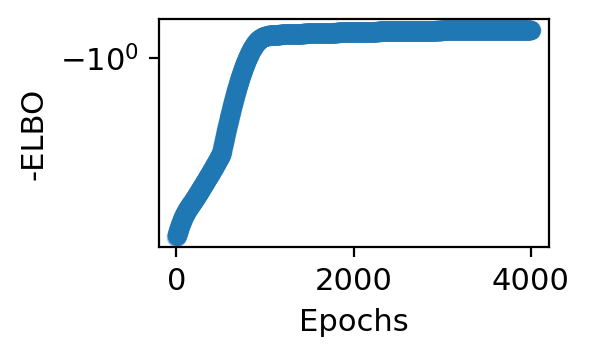

In [6]:
adata_model_pos = train_model(adata, max_epochs=4000, svi_train=False, log_every=100,
                              patient_init=45, batch_size=-1, use_gpu=0, 
                              include_prior=True, offset=False, library_size=True,
                              patient_improve=1e-4, guide_type='auto_t0_constraint', train_size=1.0)                              

                        MAE
label                      
Poisson all cells  0.512477


,MAE,label
0,0.512411,Poisson all cells
1,0.512299,Poisson all cells
2,0.512497,Poisson all cells
3,0.512550,Poisson all cells
4,0.512718,Poisson all cells
5,0.512504,Poisson all cells
6,0.512252,Poisson all cells
7,0.512711,Poisson all cells
8,0.511961,Poisson all cells
9,0.512865,Poisson all cells


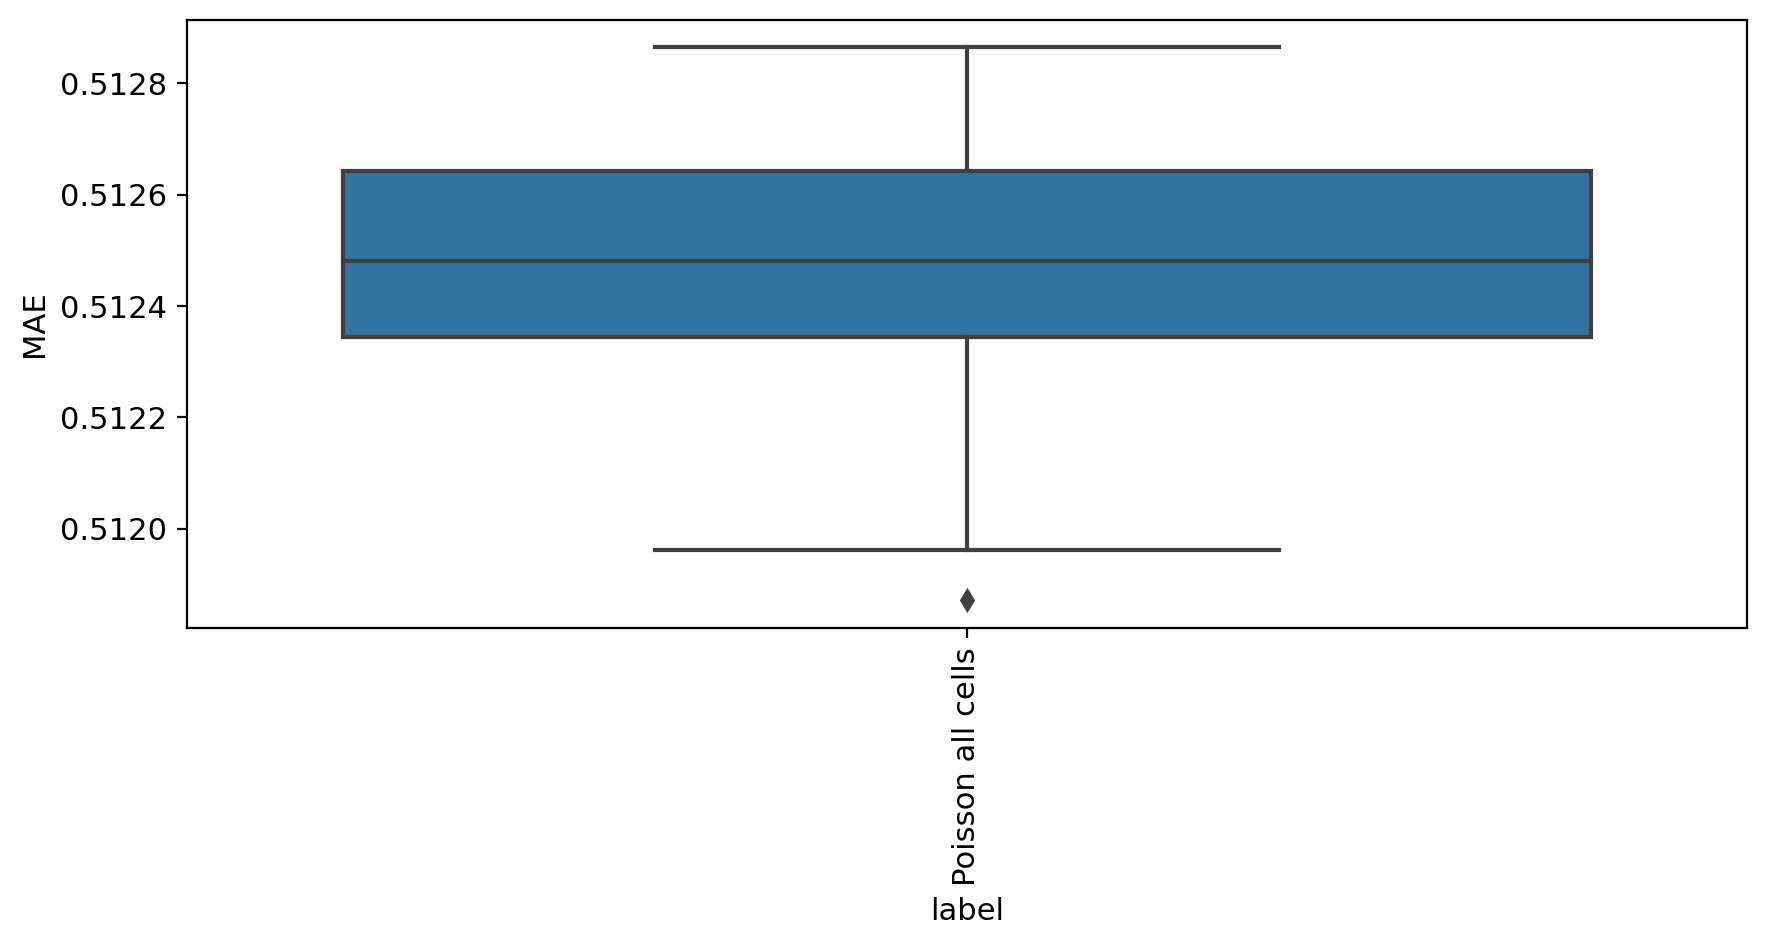

In [7]:
mae_evaluate(adata_model_pos[1], adata)

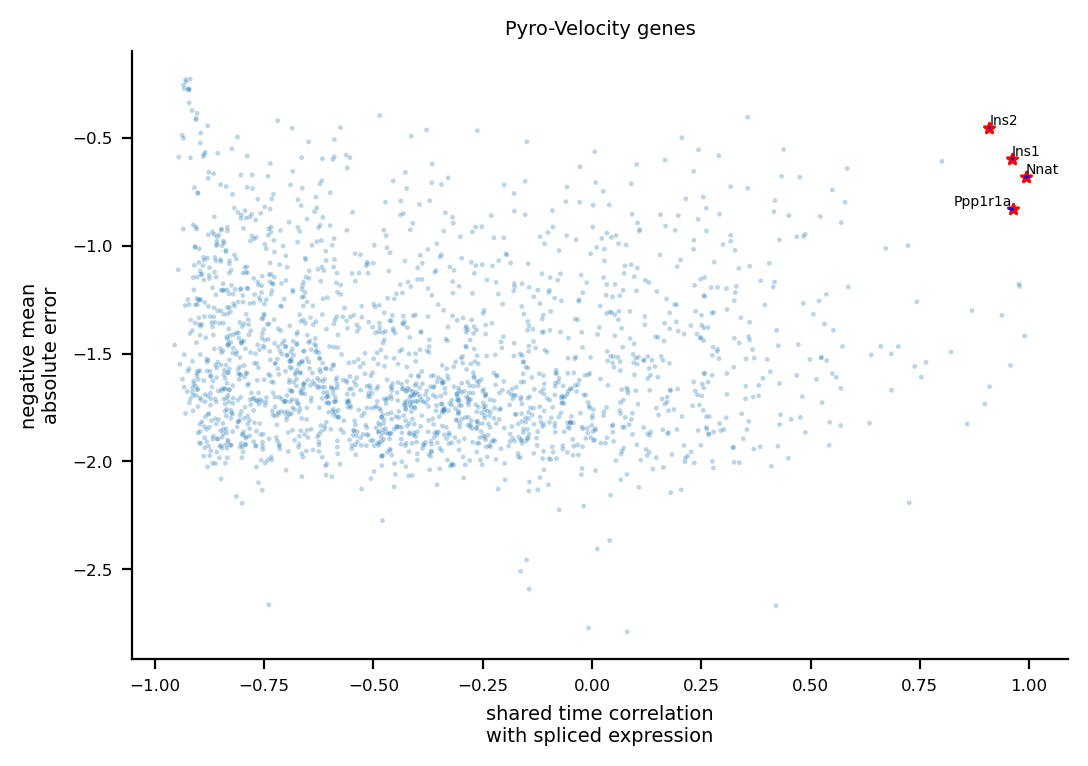

In [8]:
fig, ax = plt.subplots()
volcano_data, _ = plot_gene_ranking([adata_model_pos[1]], [adata], ax=ax, time_correlation_with='st')

In [9]:
v_map_all, embeds_radian, fdri = vector_field_uncertainty(adata, adata_model_pos[1], basis='umap', n_jobs=10)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)


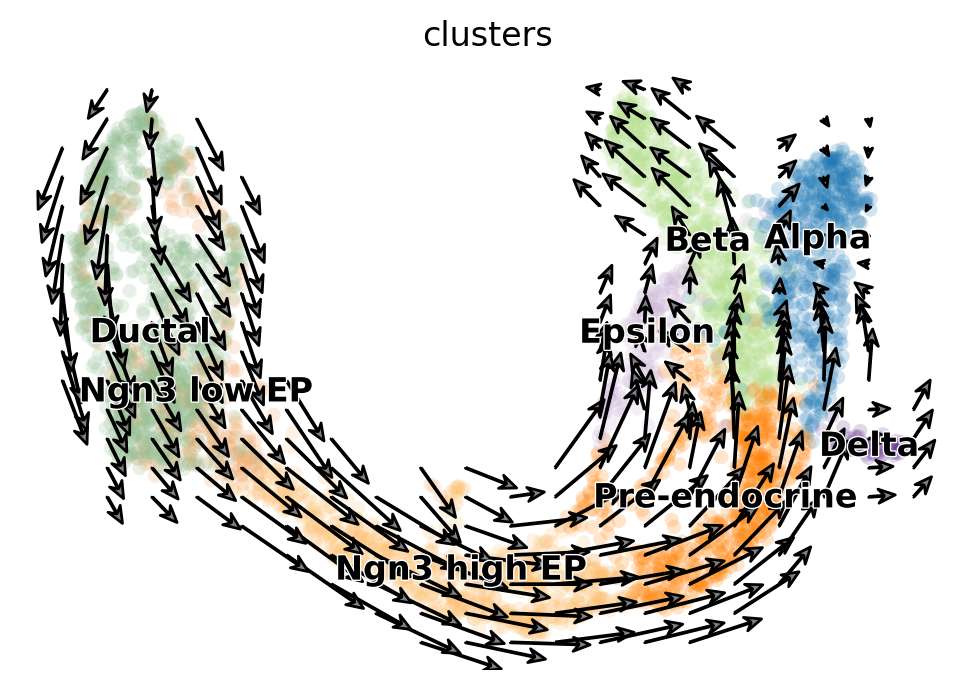

In [10]:
fig, ax = plt.subplots()
embed_mean = plot_mean_vector_field(adata_model_pos[1], adata, ax=ax, n_jobs=10)

# Assemble figure

V_grid.........
V_grid.........
60 50 40
0.0
SpearmanrResult(correlation=0.9496544470937454, pvalue=0.0)
Nnat
[ 9.427586   1.480276   9.09433   ...  1.6077774 14.994302  10.949259 ]
Ppp1r1a
[ 9.427586   1.480276   9.09433   ...  1.6077774 14.994302  10.949259 ]
Ins1
[ 9.427586   1.480276   9.09433   ...  1.6077774 14.994302  10.949259 ]
Ins2
[ 9.427586   1.480276   9.09433   ...  1.6077774 14.994302  10.949259 ]


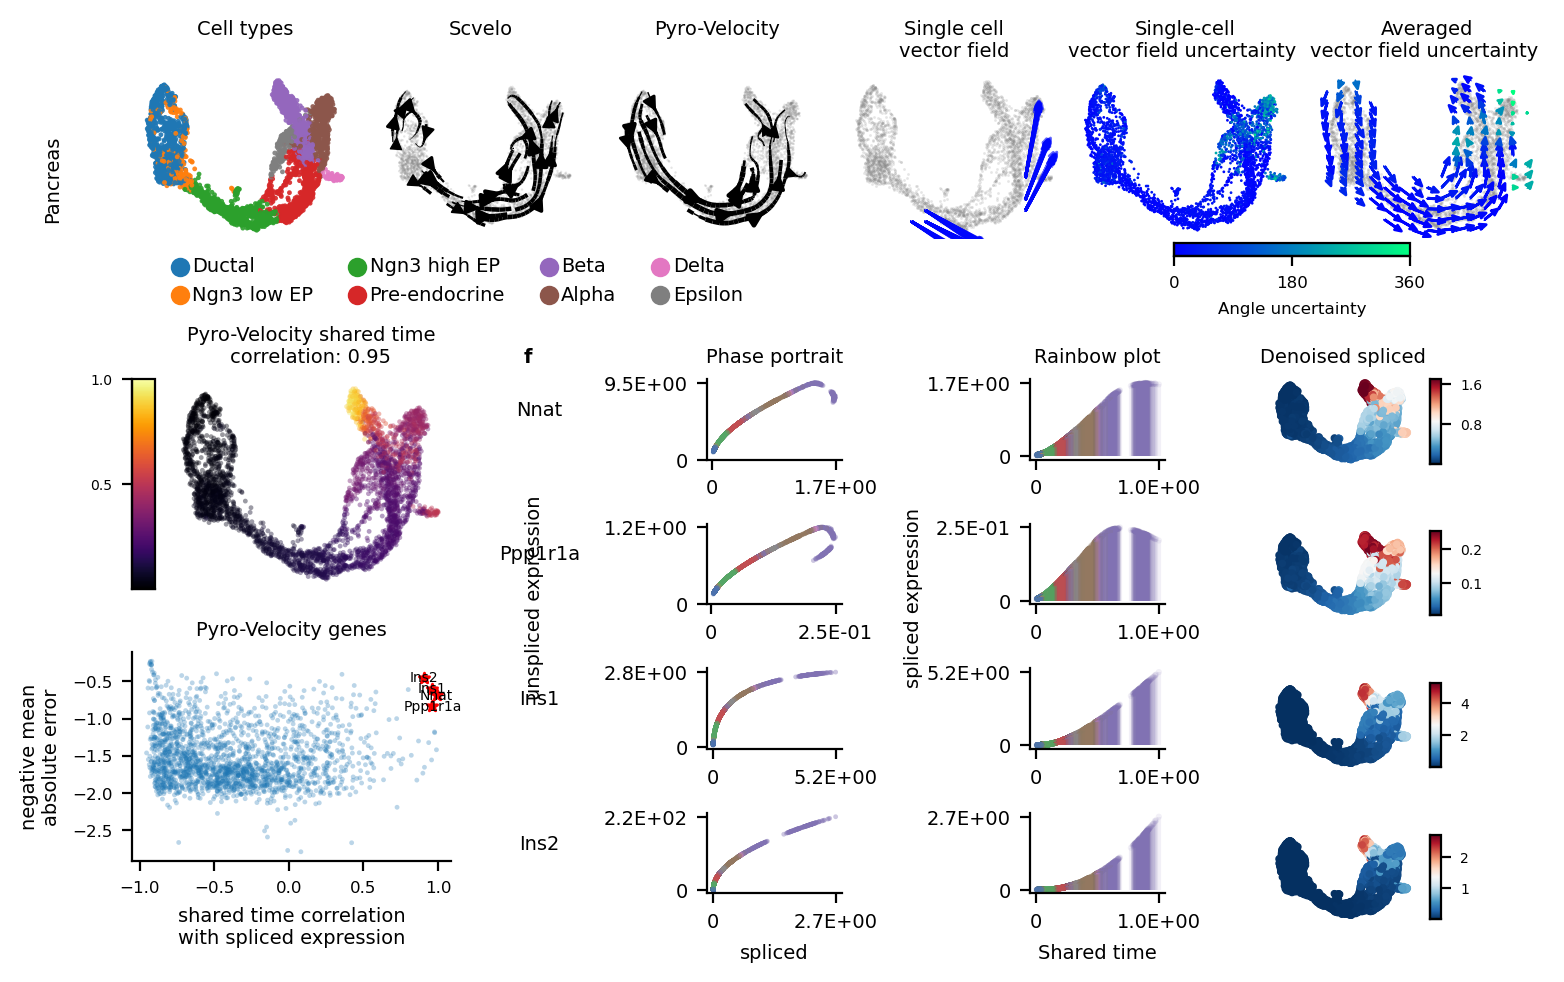

In [11]:
fig = plt.figure(figsize=(7.07, 4.5))
subfig_A = fig.subfigures(2, 1, wspace=0.0, hspace=0, height_ratios=[1.2, 3])
dot_size = 3
font_size = 7

ress = pd.DataFrame({"cell_type": adata.obs['clusters'].values,
                     "X1": adata.obsm['X_umap'][:,0],
                     "X2": adata.obsm['X_umap'][:,1]})
subfig_A0 = subfig_A[0].subfigures(1, 2, wspace=0.0, hspace=0, width_ratios=[4, 2])

ax = subfig_A0[0].subplots(1, 4)
sns.scatterplot(x='X1', y='X2', data=ress, alpha=0.9, s=dot_size,
                linewidth=0, edgecolor="none", hue='cell_type', 
                ax=ax[0], legend='brief')
ax[0].axis('off')
ax[0].set_title("Cell types\n", fontsize=font_size)
ax[0].legend(bbox_to_anchor=[2.9, -0.01], ncol=4, prop={'size': font_size}, fontsize=font_size, frameon=False)
kwargs = dict(color='gray', density=.8, add_margin=.1, s=dot_size,
              show=False, alpha=.2, min_mass=3.5, frameon=False)
scv.pl.velocity_embedding_stream(adata, fontsize=font_size, ax=ax[1], title='', **kwargs)
ax[1].set_title("Scvelo\n", fontsize=7)

scv.pl.velocity_embedding_stream(adata, fontsize=font_size, basis='umap', 
                                 title='', ax=ax[2], vkey='velocity_pyro', **kwargs)
ax[2].set_title("Pyro-Velocity\n", fontsize=7)

# plot_arrow_examples(adata_train, np.transpose(v_map_all, (1, 2, 0)), embeds_radian, ax=ax[3],
#                     n_sample=30, fig=fig, basis='umap', scale=0.004, alpha=0.18)
plot_arrow_examples(adata, np.transpose(v_map_all, (1, 2, 0)), embeds_radian, ax=ax[3],
                    n_sample=30, fig=fig, basis='umap', scale=0.008, alpha=0.2, index=5,
                    scale2=0.015, num_certain=6)
ax[3].set_title("Single cell\nvector field", fontsize=7)

plot_vector_field_uncertain(adata, embed_mean, embeds_radian, 
                            fig=subfig_A0[1], cbar=True, basis='umap', scale=0.05)

subfig_A0[0].subplots_adjust(hspace=0.2, wspace=0.1, left=0.01, right=0.99, top=0.99, bottom=0.35)
subfig_A0[1].subplots_adjust(hspace=0.2, wspace=0.1, left=0.01, right=0.99, top=0.99, bottom=0.35)

subfig_A[0].text(-0.06, 0.58, "Pancreas", size=7, rotation="vertical", va="center")

subfig_B = subfig_A[1].subfigures(1, 2, wspace=0.0, hspace=0, width_ratios=[1.6, 4])
##subfig_B[0].subplots_adjust(hspace=0.2, wspace=0.1, left=0.01, right=0.99, top=0.99, bottom=0.1)

ax = subfig_B[0].subplots(2, 1)
plot_posterior_time(adata_model_pos[1], adata, ax=ax[0], fig=subfig_B[0], addition=False)
subfig_B[0].subplots_adjust(hspace=0.3, wspace=0.1, left=0.01, right=0.8, top=0.92, bottom=0.17)

volcano_data2, _ = plot_gene_ranking([adata_model_pos[1]], [adata], ax=ax[1],
                                    time_correlation_with='st', assemble=True)
_ = rainbowplot(volcano_data2, adata, adata_model_pos[1], subfig_B[1], data=['st', 'ut'], num_genes=4)

In [12]:
fig.savefig("pancreas_output_figure1.tif", facecolor=fig.get_facecolor(), bbox_inches='tight', edgecolor='none', dpi=300)

V_grid.........
60 50 40


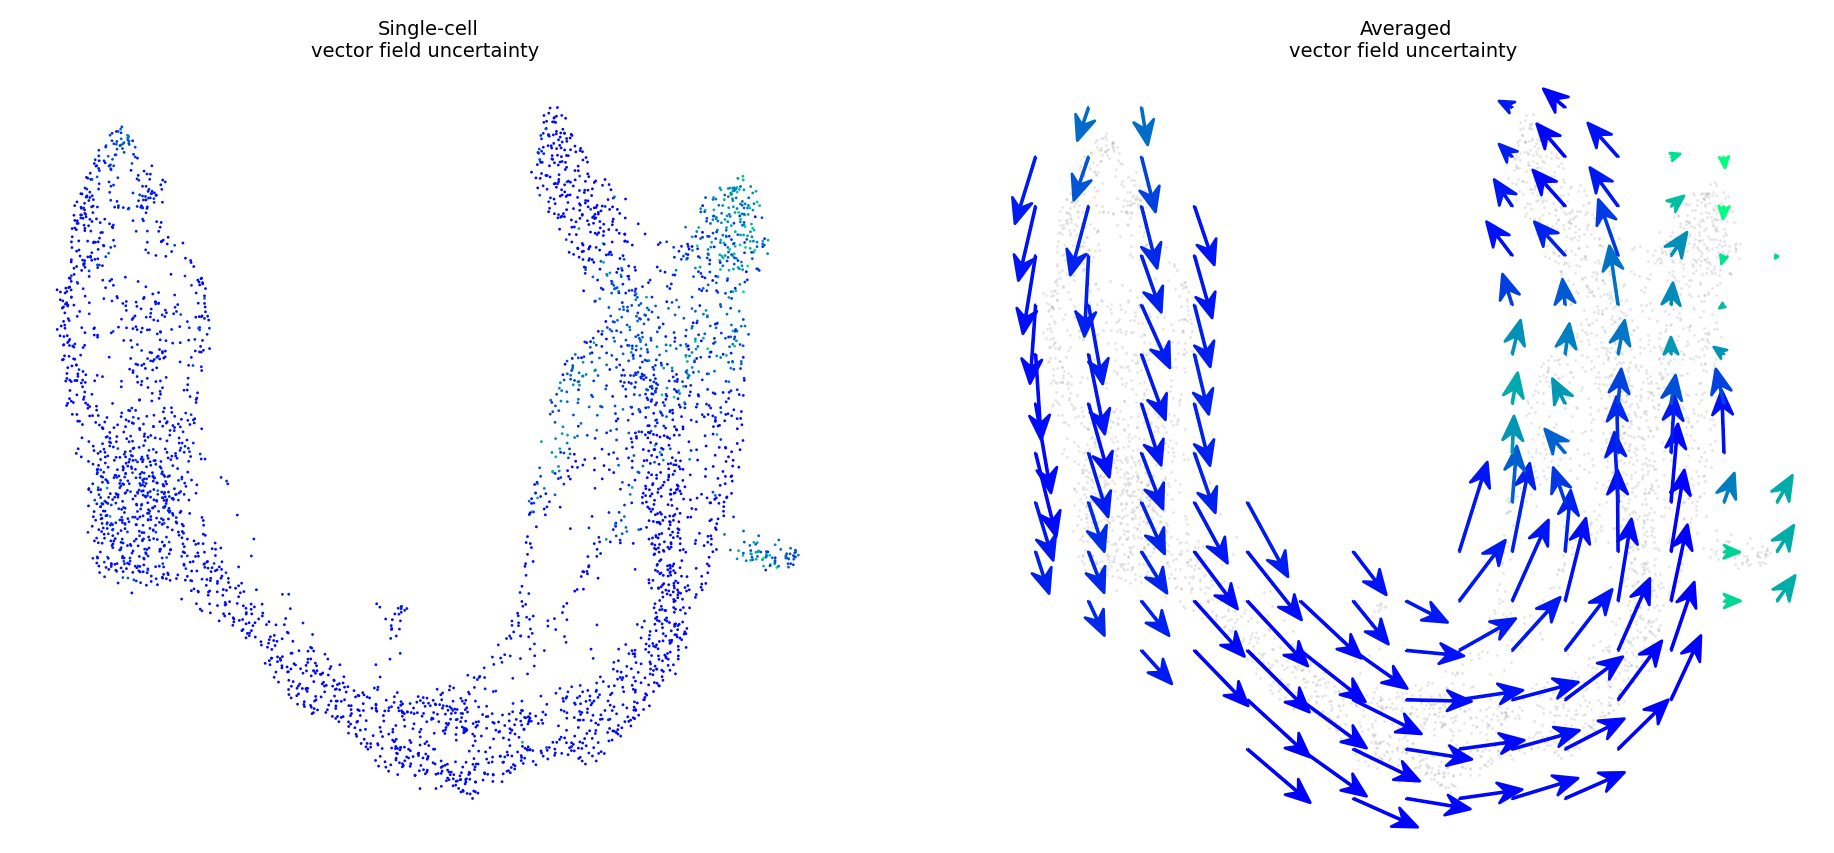

In [13]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(11.5, 5)
plot_vector_field_uncertain(adata, embed_mean, embeds_radian, 
                            ax=ax,
                            fig=fig, cbar=False, basis='umap', scale=0.05)

# More uncertainty evaluation metrics

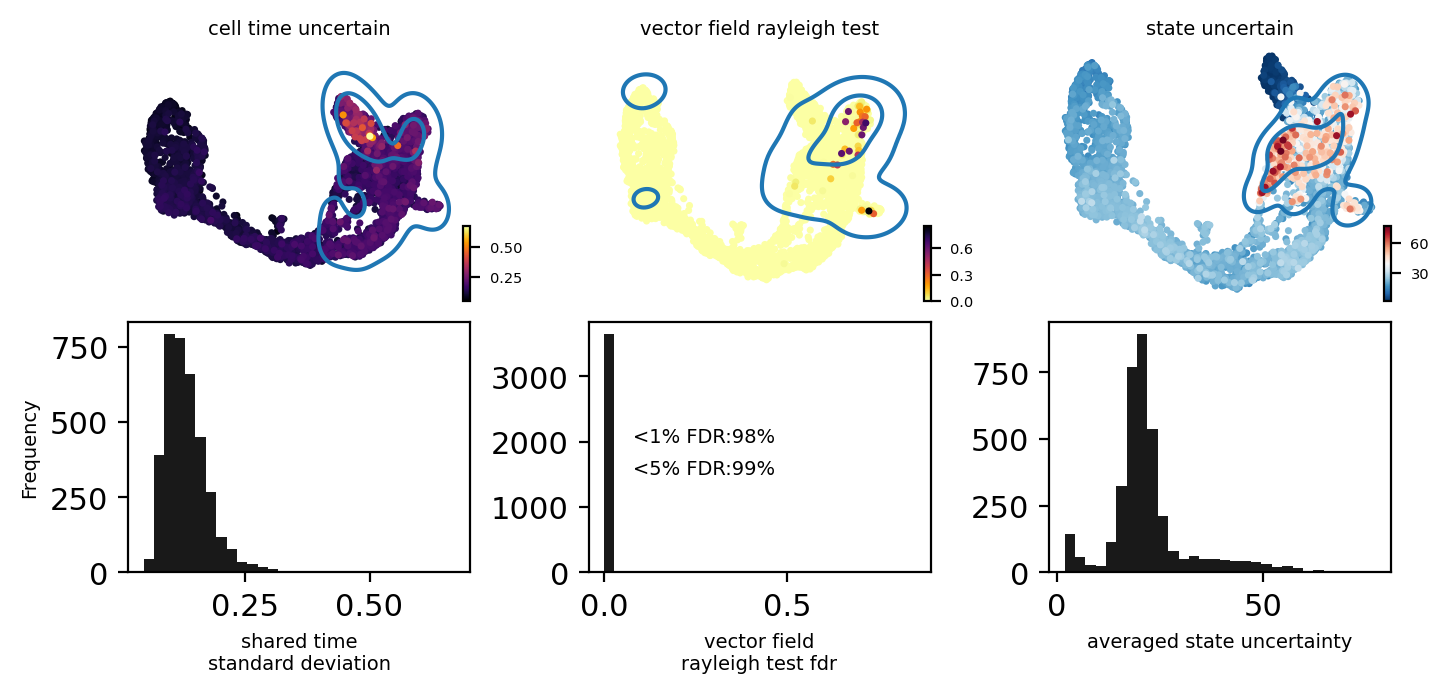

In [14]:
from pyrovelocity.plot import plot_state_uncertainty
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(7.07, 3.5)
pos = adata_model_pos[1]
bin = 30
adata.obs['cell_time_uncertain'] = adata_model_pos[1]['cell_time'].std(0).flatten()
scv.pl.scatter(adata, c='cell_time_uncertain', ax=ax[0][0], show=False, cmap='inferno', fontsize=7)

_ = ax[1][0].hist(adata.obs.cell_time_uncertain, bins=bin, color='black', alpha=0.9)
ax[1][0].set_xlabel("shared time\nstandard deviation", fontsize=7)
select = adata.obs['cell_time_uncertain'] > np.quantile(adata.obs['cell_time_uncertain'], 0.9)
sns.kdeplot(adata.obsm['X_umap'][:, 0][select],
            adata.obsm['X_umap'][:, 1][select], ax=ax[0][0], levels=3, fill=False)

adata.obs['vector_field_rayleigh_test'] = fdri
scv.pl.scatter(adata, c='vector_field_rayleigh_test', ax=ax[0][1], show=False, cmap='inferno_r', fontsize=7)
select = adata.obs['vector_field_rayleigh_test'] > np.quantile(adata.obs['vector_field_rayleigh_test'], 0.9)
sns.kdeplot(adata.obsm['X_umap'][:, 0][select],
            adata.obsm['X_umap'][:, 1][select], ax=ax[0][1], levels=3, fill=False)

_ = ax[1][1].hist(adata.obs.vector_field_rayleigh_test, bins=bin, color='black', alpha=0.9)
ax[1][1].set_xlabel("vector field\nrayleigh test fdr", fontsize=7)
ax[1][1].text(0.08, 2000, "<1%% FDR:%s%%" % int((fdri < 0.01).sum()/fdri.shape[0]*100), fontsize=7)
ax[1][1].text(0.08, 1500, "<5%% FDR:%s%%" % int((fdri < 0.05).sum()/fdri.shape[0]*100), fontsize=7)

fig.subplots_adjust(hspace=0.3, wspace=0.7, left=0.01, right=0.8, top=0.92, bottom=0.17)
plot_state_uncertainty(pos, adata, kde=False, data='denoised', top_percentile=0.9, ax=ax[0][2])

_ = ax[1][2].hist(adata.obs['state_uncertain'], bins=bin, color='black', alpha=0.9)
ax[1][2].set_xlabel("averaged state uncertainty", fontsize=7)
select = adata.obs['state_uncertain'] > np.quantile(adata.obs['state_uncertain'], 0.9)
sns.kdeplot(adata.obsm['X_umap'][:, 0][select],
            adata.obsm['X_umap'][:, 1][select], ax=ax[0][2], levels=3, fill=False)

ax[1][0].set_ylabel("Frequency", fontsize=7)
fig.tight_layout()

In [15]:
fig.savefig("pancreas_output_figure2.tif", facecolor=fig.get_facecolor(), bbox_inches='tight', edgecolor='none', dpi=300)

In [16]:
adata.write("pancreas_model_adata.h5ad")